In [1]:
using LinearAlgebra, ToeplitzMatrices
using Plots
using BSON: @load

Data from video is stored in "vineQVF.bson", and contains:

Q, a matrix containing the pin joint angles at each timestep: 
    $[q^{(1)} ... q^{(K)}]$
    
V, a matrix containing the pin joint angular velocities at each timestep: 
    $[v^{(1)} ... v^{(K)}]$
    
F, a matrix containing the pin joint torques at each timestep:
    $[f^{(1)} ... f^{(K)}]$

In [2]:
# load dataset
@load "vineQVF.bson" Q V F
numPins, numTimesteps = size(Q)

(40, 165)

In [3]:
# set up for optimization Ax = y
A = [Q' V']
A = kron(A,Matrix(I,numPins,numPins))

y = vec(F)

numParams = 2*numPins^2 # size of x

3200

In [4]:
# weights matrix for regularization
v = .1*[.1;.1;[i for i = range(.3,1,length = numPins-2)]]
WK = Toeplitz(v,v)
WC = Toeplitz(v,v)
W = Diagonal([vec(WK);vec(WC)])

# print WK
WK

40×40 Toeplitz{Float64,Complex{Float64}}:
 0.01       0.01       0.03       …  0.0962162  0.0981081  0.1
 0.01       0.01       0.01          0.0943243  0.0962162  0.0981081
 0.03       0.01       0.01          0.0924324  0.0943243  0.0962162
 0.0318919  0.03       0.01          0.0905405  0.0924324  0.0943243
 0.0337838  0.0318919  0.03          0.0886486  0.0905405  0.0924324
 0.0356757  0.0337838  0.0318919  …  0.0867568  0.0886486  0.0905405
 0.0375676  0.0356757  0.0337838     0.0848649  0.0867568  0.0886486
 0.0394595  0.0375676  0.0356757     0.082973   0.0848649  0.0867568
 0.0413514  0.0394595  0.0375676     0.0810811  0.082973   0.0848649
 0.0432432  0.0413514  0.0394595     0.0791892  0.0810811  0.082973
 0.0451351  0.0432432  0.0413514  …  0.0772973  0.0791892  0.0810811
 0.047027   0.0451351  0.0432432     0.0754054  0.0772973  0.0791892
 0.0489189  0.047027   0.0451351     0.0735135  0.0754054  0.0772973
 ⋮                                ⋱                        
 0.07918

minimize $||Ax - y||^2 + x^{\top}Wx$

In [5]:
# solve regularized least squares
x = (A'*A + W)\(A'*y)
KCmatrix = reshape(x, numPins, 2*numPins);

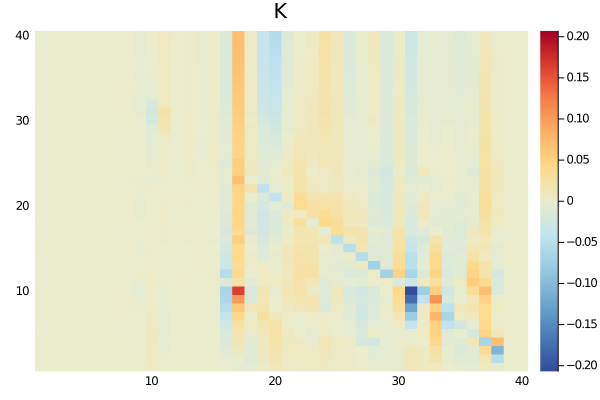

In [6]:
# show K
K = KCmatrix[:, 1:numPins]
lim = maximum(abs.(K))
theme(:vibrant)
heatmap(reverse(K, dims=1), title="K", clim=(-lim,lim))

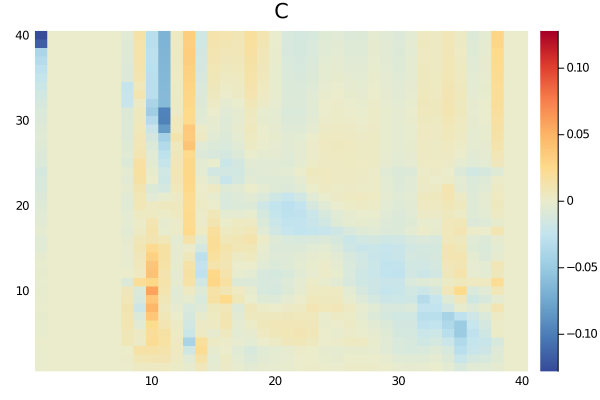

In [7]:
# show C
C = KCmatrix[:, numPins+1:end]
lim = maximum(abs.(C))
theme(:vibrant)
heatmap(reverse(C, dims=1), title="C", clim=(-lim,lim))

In [8]:
# compute goodness of fit
SSR = (A*x-y)'*(A*x-y)
SST = norm(y .- sum(y)/length(y))^2
Rsq = 1.0 - SSR/SST

0.7554433579198858